In [1]:
import mesa
import matplotlib
import os
import numpy as np
from random import randrange,shuffle
import scipy.stats as stats
from scipy.spatial import distance,distance_matrix
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from copy import copy
import networkx as nx
import pandas as pd

In [2]:
def create_epsilon_array(n_agents=500, n_opinions=3,log_norm=True,mean=0.5,std=0.2,mode='column_vec'):
    """Create random values of equanimity (epsilon), in the shape of a matrix, row vector (row_vec), column vector (col_vec), or scalar, representing equanimity (epsilon).
    Values are either drawn from a normal distribution (log_norm==False) with mean and std, or from an exponentiated normal distribution, divided by 2.
    The output of this function can be given to the 'epsilon' parameter of the run_model() function."""
    mode = mode.lower().strip()
    # Draw epsilon values from log-normal distribution (divided by two):
    if log_norm == True:
        # Create a matrix:
        if mode == 'matrix':
            E = np.exp(np.random.normal(loc=mean,scale=std,size=(n_agents,n_opinions)))/2
        # Create a column vector:
        elif (mode == 'column_vec') or (mode == 'col_vec') or (mode == 'individual'):
            E = np.exp(np.random.normal(loc=mean,scale=std,size=n_agents))/2
            E = E.reshape(n_agents,1)
        # Create a row vector:
        elif (mode == 'row_vec') or (mode == 'issue_specific'):
            E = np.exp(np.random.normal(loc=mean,scale=std,size=n_opinions))/2
            E = E.reshape(1,n_opinions)
        # Create a scalar:
        elif (mode == 'singular') or (mode == 'scalar'):
            E = np.exp(np.random.normal(loc=mean,scale=std,size=1))/2
            E = E[0]
        else:
            print("ERROR: Mode unknown!")
            return(None)
    # Draw epsilon values from normal distribution:
    else:
        if mode == 'matrix':
            E = stats.truncnorm(-mean/std, 1 / std, loc=mean, scale=std).rvs(n_agents*n_opinions).reshape(n_agents,n_opinions)
        elif (mode == 'column_vec') or (mode == 'individual'):
            E = stats.truncnorm(-mean/std, 1 / std, loc=mean, scale=std).rvs(n_agents).reshape(n_agents,1)
        elif (mode == 'row_vec') or (mode == 'issue_specific'):
            E = stats.truncnorm(-mean/std, 1 / std, loc=mean, scale=std).rvs(n_opinions).reshape(1,n_opinions)
        elif (mode == 'singular') or (mode == 'scalar'):
            E = stats.truncnorm(-mean/std, 1 / std, loc=mean, scale=std).rvs(1)[0]
        else:
            print("ERROR: Mode unknown!")
            return(None)
    return(E)

In [3]:
def initiate_opinion_matrix(n_agents=500,n_opinions=3,distribution='uniform',std=0.5):
    """
    Create the initial, random n_agents by n_opinions opinion matrix. Initial opinions can be distributed uniformely at random,
    or normally around the origin of opinion space, with standard deviation std.
    """
    # Create uniformly distributed opinion values:
    if distribution == 'uniform':
        O = np.random.uniform(-1,1,(n_agents,n_opinions))
    # Create truncated normal distribution (values between -1 and 1), with mean 0 and standard deviation std.:
    elif distribution == 'normal':
        O = stats.truncnorm(-1 / std, 1 / std, loc=0, scale=std).rvs(n_agents*n_opinions).reshape(n_agents,n_opinions)
    else:
        print('ERROR: initial opinion distribution "' + str(distribution) + '" not recognized!')
    return(O)

In [4]:
def relation_vec(O,Q,e=0.5,aggregation_method = 'mean'):
    """
    Compute vector of relations R between agents in corresponding rows of opinion matrices O and Q.
    Parameter e determines degree of 3 in agents.
    The aggregation_method determines how the SGMs of various issue dimensions are integrated:
    If aggregation_method == 'mean', SGMs are averaged with the arithmetic mean.
    If aggregation_method == 'abs_weighted_mean', a weighted average of the SGMs is computed, with the
    absolute SGMs as weights.
    If aggregation_method == 'self_weighted_mean', the weights are set to the absolute opinion vector of agent i.

    """

    # Pointwise product of O and Q:
    p_mat = np.multiply(O,Q)
    # Multiply signs of p_mat with absolute p_mat to the power of e:
    m_mat = np.sign(p_mat)*np.power(np.abs(p_mat),e)
    # Average the resulting products row-wise:
    if aggregation_method == 'mean':
        R = np.mean(m_mat,axis=0)
    # Row-wise average, weighted by absolute magnitude of m_mat entries (so that stronger agreement/disagreement counts more):
    elif aggregation_method == 'abs_weighted_mean':
        R_ = np.average(m_mat, axis=1, weights=np.abs(m_mat))
    # Row-wise average, weighted by absolute magnitude of O entries (so that stronger opinions of i count more):
    elif aggregation_method == 'self_weighted_mean':
        R = np.average(m_mat, axis=1, weights=np.abs(O))
    else:
        print('ERROR: Aggregation Method "' + str(aggregation_method) + '" not recognized!')
    #R = R.reshape([O.shape[0],1])
    return(R)

In [5]:
def bias_relation(R,beta=0):
    """
    Introduce a bias beta into the interpersonal relation Rij.
    Beta can be between -1 (extreme negative bias) and 1 (extreme positive bias).
    Resulting biased Rij values will always be between -1 and 1.
    """
    if beta == 0:
        return(R)
    else:
        return((1-np.abs(beta))*R+beta)

In [6]:
def balanced_mat(R,Q,e=0.5):
    """
    Compute balanced opinion matrix B.
    """
    p_mat = np.multiply(R,Q)
    B = np.sign(p_mat)*np.power(np.abs(p_mat),e)
    return(B)

In [7]:
def update_opinion_mat(O,Q,R,e=.5,alpha=.05):

    # Compute the balanced opinion matrix B
    B = balanced_mat(R, Q, e=e)

    # Update the opinion matrix O_new
    O_new = O + alpha * (B - O)

    return (O_new)

In [8]:
def add_noise(O_new,zeta=0.01):
    """
    Add random normal noise with mean zero and standard deviation zeta to opinion matrix. If, after adding noise, any values of
    O exceed the boundaries of the opinion space (O < -1 or O > 1), they are 'reflected back' into the opinion space.
    """
    # If noise parameter is 0, return unchanged opinion matrix:
    if zeta == 0:
        return(O_new)
    else:
        # Look up number of agents and opinion dimensions:
        n_agents,n_opinions = O_new.shape
        # Generate random normal noise matrix Z:
        Z = stats.truncnorm(-1 / zeta, 1 / zeta, loc=0, scale=zeta).rvs(n_agents*n_opinions).reshape(n_agents,n_opinions)
        # Add noise matrix to opinion matrix:
        O_noise = O_new + Z
        # As long as there are values > 1:
        while np.any(O_noise > 1):
            # Reflect values over 1:
            O_noise = np.where(O_noise > 1,1-(O_noise-1),O_noise)
        # As long as there are values < -1:
        while np.any(O_noise < -1):
            # Reflect values below -1:
            O_noise = np.where(O_noise < -1,-1+np.abs(O_noise+1),O_noise)
        # Return matrix with noise:
        return(O_noise)

In [9]:
def Polarization2(model):
    exp = 2
    agent_opinions = [agent.opinion_values for agent in model.schedule.agents if agent.burt_score < agent.threshold]
          #rows = self.num_nodes
          #columns = self.num_opinions
          #matrix = np.array(agent_opinions).reshape(rows, columns)
    matrix = np.vstack(agent_opinions)
          # Sum of: Minkowski distance between all row vectors of M raised to the power of exp:
    dist_sum = np.power(distance_matrix(matrix,matrix,p=2),exp).sum()
          # Maximum possible distance:
    max_dist = distance.minkowski(np.ones(model.num_opinions),-np.ones(model.num_opinions),p=2)**exp
          # Maximum number of pairs with maximum distance:
    max_pairs = (model.num_nodes**2)/2
          # Divide sum of distances by product of maximum distance and maximum number of pairs at max distance:
    normalized_dist_sum = dist_sum/(max_dist*max_pairs)
          # Take exp-th root of normalized_dist_sum:
    polarization = normalized_dist_sum**(1/exp)
    return(polarization)

In [10]:
def Alignment2(model):
    """Performs a PCA on opinion matrix O and returns the proportion of variance explained by the first component."""
    agent_opinions = [agent.opinion_values for agent in model.schedule.agents if agent.burt_score < agent.threshold]
    matrix = np.vstack(agent_opinions)
    expected = 1/matrix.shape[1]
    sm = StandardScaler().fit_transform(matrix)
    pca = PCA(n_components=1)
    principalComponents = pca.fit_transform(sm)
    explained_variance = pca.explained_variance_ratio_[0]
    alignment = (explained_variance - expected)/(1-expected)
    return(alignment)

In [11]:
def Extremeness2(model):
    """Computes extremeness (mean absolute value of elements) of opinion matrix O."""
    agent_opinions = [agent.opinion_values for agent in model.schedule.agents if agent.burt_score < agent.threshold]
          #rows = self.num_nodes
          #columns = self.num_opinions
          #matrix = np.array(agent_opinions).reshape(rows, columns)
    matrix = np.vstack(agent_opinions)
    O_matrix = np.absolute(matrix)
    extremeness = O_matrix.mean()
    return(extremeness)

In [12]:
# Define a function to reduce the memory usage of a dataframe
# Source: https://stackoverflow.com/a/67209931
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Define your agent class
class MyAgent(mesa.Agent):
    """ An agent in a weighted balance opinion model."""

    def __init__(self, unique_id, model, epsilon_value, opinion_values, burt_score, thresh, radius = 1, alpha = .2):
        super().__init__(unique_id, model)
        self.epsilon_value = epsilon_value
        self.opinion_values = opinion_values
        self.X = self.opinion_values
        self.radius = radius
        #constant alpha which is part of the update opinion concept of new opinion= current opinion + alpha*(balanced opinion - current opinion)
        self.alpha = alpha
        self.threshold = thresh
        self.burt_score = burt_score


    def step(self):
        if self.burt_score < self.threshold: 
            neighbors_nodes = self.model.grid.get_neighborhood(self.pos, include_center=False, radius = self.radius)
            each_neighbor = self.model.grid.get_cell_list_contents(neighbors_nodes)
            chosen_neighbor = self.random.choice(each_neighbor)
            q = chosen_neighbor.opinion_values
            R = relation_vec(O=self.opinion_values, Q=q, e=chosen_neighbor.epsilon_value)
            B = balanced_mat(R, Q=q, e=chosen_neighbor.epsilon_value)
            X = update_opinion_mat(O=self.opinion_values, Q=q, R=R, e=chosen_neighbor.epsilon_value, alpha=self.alpha)
            #O_new = add_noise(O_new)
            self.X = np.around(X, 4)
        elif self.burt_score >= self.threshold:
           X = self.opinion_values
           self.X = np.around(X, 4)

    def advance(self):
        self.opinion_values = self.X
        #print(self.opinion_values)

# Define your model class
class WeightedBalanceModel(mesa.Model):
    """ A model of the opinion dynamics """
    def __init__(self, threshold = 1, n_agents = 100, n_opinions=3, mean = 0, std = 0.8, radius = 1, network = None):
        #self.agent = MyAgent()
        #create the nodes
        self.running = True
        self.num_nodes = n_agents
        self.num_opinions = n_opinions
        self.threshold = threshold
        self.G = nx.barabasi_albert_graph(n=self.num_nodes, m=2)
        struct_hole = nx.constraint(self.G)
        self.grid = mesa.space.NetworkGrid(self.G)
        self.mean = mean
        self.std = std
        self.radius = radius

        self.schedule = mesa.time.SimultaneousActivation(self)
        #creat the graph
        if network == None:
          self.G = nx.barabasi_albert_graph(n=self.num_nodes, m=2)
          struct_hole = nx.constraint(self.G)
          self.grid = mesa.space.NetworkGrid(self.G)
        elif network == 'Wattz-Strogatz':
          self.G = nx.watts_strogatz_graph(n=self.num_nodes, k=2, p = .3)
          struct_hole = nx.constraint(self.G)
          self.grid = mesa.space.NetworkGrid(self.G)
        elif network == 'Connected Wattz-Strogatz':
          self.G = nx.connected_watts_strogatz_graph(n=self.num_nodes, k=2, p = .3)
          struct_hole = nx.constraint(self.G)
          self.grid = mesa.space.NetworkGrid(self.G)

        # Create a dataframe to store the agents' attributes
        self.agents_df = pd.DataFrame()

        #create agents
        agent_id = 1
        e = create_epsilon_array(n_agents=self.num_nodes,n_opinions=self.num_opinions, mean = self.mean, std= self.std, mode='matrix')
        O = initiate_opinion_matrix(n_agents=self.num_nodes,n_opinions=self.num_opinions)
        for i, node in enumerate(self.G.nodes()):
            epsilon_value = e[i] if i < len(e) else 0
            opinion_values = O[i]
            burt_score = 1 - struct_hole[i]
            thresh = self.threshold
            radius = self.radius
            agent = MyAgent(agent_id, self, epsilon_value, opinion_values, burt_score, thresh, radius  )
            self.schedule.add(agent)
            agent_id += 1
            #add agent
            self.grid.place_agent(agent, node)
            #print(agent_id, burt_score, thresh)

            # Append the agent's attributes to the dataframe
            self.agents_df = pd.concat([self.agents_df, 
                                        pd.DataFrame([{
                                            "id": agent.unique_id, 
                                            "epsilon_value": agent.epsilon_value,
                                            "opinion_values": agent.opinion_values,
                                            "burt_score": agent.burt_score,
                                            "threshold": agent.threshold,
                                            "radius": agent.radius,
                                            "alpha": agent.alpha}])],
                                       ignore_index=True)

        # Reduce the memory usage of the dataframe
        self.agents_df = reduce_mem_usage(self.agents_df)

        # Define the data collector for the model
        self.datacollector = mesa.DataCollector(
            #agent_reporters={"OpinionValues": "opinion_values"},
            model_reporters={"Polarization": Polarization2,
                             "Alignment" : Alignment2,
                             "Extremeness": Extremeness2}
        )

    def get_opinion_values_data(self):
          # Use infer_objects to automatically infer the best data types for the dataframe
          return self.datacollector.get_agent_vars_dataframe().reset_index().infer_objects()      
    def step(self):
        #Advance the model one step.

        self.schedule.step()
        self.datacollector.collect(self)

In [13]:
#from opinion_server import server
#server.port= 8521
#server.launch()

In [14]:
model = WeightedBalanceModel(n_agents= 5, n_opinions= 3, radius = 3, threshold = 1)
opinion = []
for i in range(100):
    model.step()

#data = model.datacollector.get_agent_vars_dataframe().reset_index()
polarization_data = model.datacollector.get_model_vars_dataframe().reset_index()


print(polarization_data)

Mem. usage decreased to  0.00 Mb (40.0% reduction)
    index  Polarization  Alignment  Extremeness
0       0      0.488204   0.606209     0.525647
1       1      0.416704   0.629443     0.451733
2       2      0.400368   0.637518     0.422427
3       3      0.323074   0.625809     0.352953
4       4      0.292929   0.663535     0.311020
..    ...           ...        ...          ...
95     95      0.243437   0.947057     0.201360
96     96      0.249470   0.871573     0.205347
97     97      0.247300   0.948711     0.208553
98     98      0.233091   0.937905     0.199807
99     99      0.235808   0.854150     0.203580

[100 rows x 4 columns]


In [ ]:
data1 = pd.DataFrame(polarization_data)

In [ ]:
data1.tail(20)

## Batch Testing

In [15]:
parameters =  {
    'n_agents': range(100, 1100, 100), ## range of the number of agents and the network
    'network': [None, 'Connected Wattz-Strogatz'], #type of networks, None is Barabasi's network
    #'n_opinions': range(2,6, 1), # range of the amount of opinions
    'threshold': [ .75, .85, .95, 1], # range of the Burts score that will the threshold
    'radius': [1,2], # range of the radius/distance of a neighboring node
    'mean': [0, .1, .2, .3, .4, .5], # range of the mean of the epsilon value
    'std': [0, .25, .5, .75, 1], # range of the std of the epsilon value
}

In [16]:
## Question/Need to reduce memory during runs. Possibly using Polars in model or round the floats

In [17]:
# Import the multiprocessing module
import multiprocessing


In [18]:
# Set the start method to fork or forkserver
multiprocessing.set_start_method('fork')

# Get the number of CPU cores available
num_cores = multiprocessing.cpu_count()


batch_run3 = mesa.batch_run(
    WeightedBalanceModel,
    parameters,
    iterations=1,
    max_steps=500,
    data_collection_period = 1,
    display_progress= True,
    number_processes=num_cores
)


  0%|          | 0/4800 [00:00<?, ?it/s]

Mem. usage decreased to  0.00 Mb (55.8% reduction)Mem. usage decreased to  0.00 Mb (55.8% reduction)

Mem. usage decreased to  0.00 Mb (55.8% reduction)Mem. usage decreased to  0.00 Mb (55.8% reduction)

Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 Mb (55.8% reduction)
Mem. usage decreased to  0.00 M

In [19]:
each_step_range = pd.DataFrame(batch_run3)

In [20]:
each_step_range.to_csv('batch_run_range.csv')

In [24]:
each_step_range.head(20)

,RunId,iteration,Step,n_agents,network,threshold,radius,mean,std,Polarization,Alignment,Extremeness
0,7,0,0,100,None,0.75,1,0.1,0.5,0.338370,0.104811,0.455864
1,7,0,1,100,None,0.75,1,0.1,0.5,0.294471,0.084511,0.397483
2,7,0,2,100,None,0.75,1,0.1,0.5,0.259240,0.055581,0.347584
3,7,0,3,100,None,0.75,1,0.1,0.5,0.234013,0.041144,0.311407
4,7,0,4,100,None,0.75,1,0.1,0.5,0.216772,0.065258,0.284337
5,7,0,5,100,None,0.75,1,0.1,0.5,0.205040,0.099333,0.265806
6,7,0,6,100,None,0.75,1,0.1,0.5,0.195491,0.094565,0.250719
7,7,0,7,100,None,0.75,1,0.1,0.5,0.189150,0.122803,0.241080
8,7,0,8,100,None,0.75,1,0.1,0.5,0.182874,0.157166,0.228162
9,7,0,9,100,None,0.75,1,0.1,0.5,0.181292,0.187071,0.225321


Analysis

In [22]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [23]:
df = each_step_range

In [25]:
df['network'] = df['network'].fillna(1)

In [26]:
df = df.replace('Connected Wattz-Strogatz', 2)

In [28]:
X = df[['Step','n_agents','threshold', 'network', 'radius', 'mean', 'std']]
y = df['Polarization']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set has %d examples" % X_train.shape[0])
print("Test set has %d examples" % X_test.shape[0])

Training set has 1923840 examples
Test set has 480960 examples


In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [32]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0011423419308175652


In [33]:
feature_importance = model.feature_importances_
print("Feature Importance in order of Step, Agents, Threshold, Network, Radius, Mean, Std:", feature_importance)

Feature Importance in order of Step, Agents, Threshold, Network: [4.37873910e-02 2.21241276e-04 2.10190533e-02 4.30242716e-02
 3.00983362e-02 3.78997274e-01 4.82852433e-01]


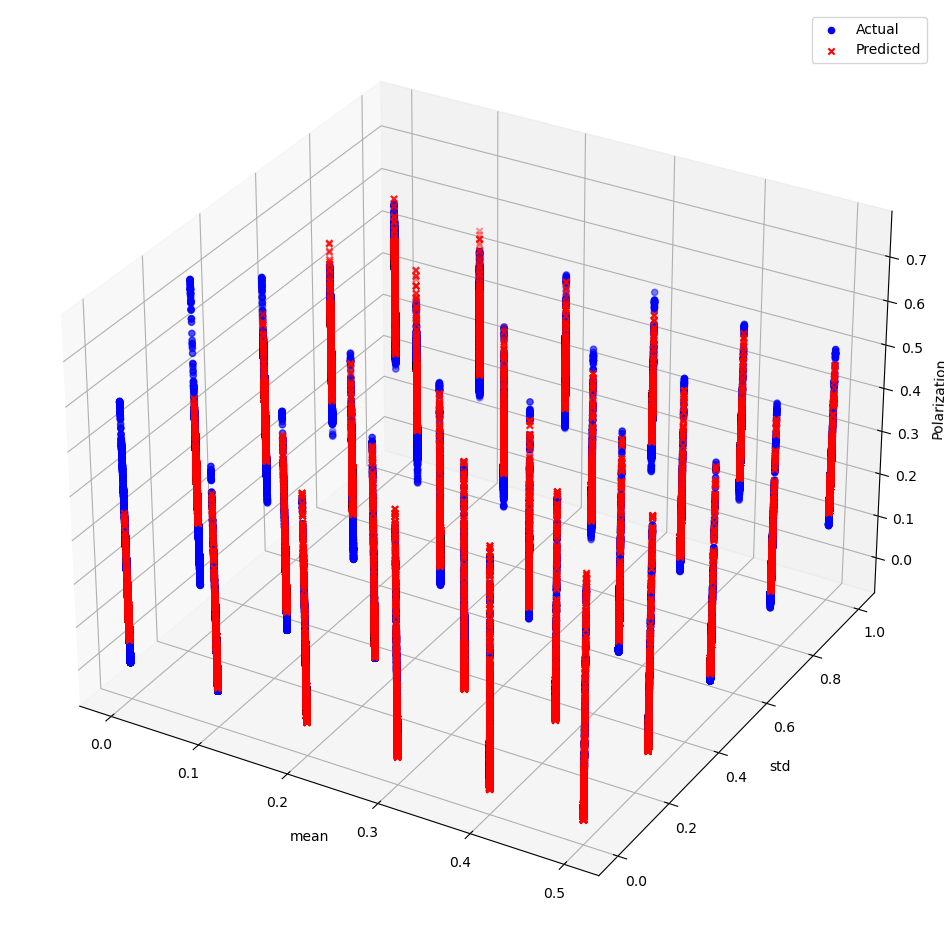

In [38]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test['mean'], X_test['std'], y_test, c='blue', marker='o', label='Actual')
ax.scatter(X_test['mean'], X_test['std'], y_pred, c='red', marker='x', label='Predicted')
ax.set_xlabel('mean')
ax.set_ylabel('std')
ax.set_zlabel('Polarization')
plt.legend()
plt.show()

In [39]:
import seaborn as sns

In [41]:
heatmap_data = pd.DataFrame({'Mean': X_test['mean'],
                             'Std': X_test['std'],
                             'Radius': X_test['radius'],
                             'Threshold': X_test['threshold'],
                             'Network': X_test['network'],
                             'Number of Agents': X_test['n_agents'],
                             'Polarization (Actual)': y_test,
                             'Polarization (Predicted)': y_pred})

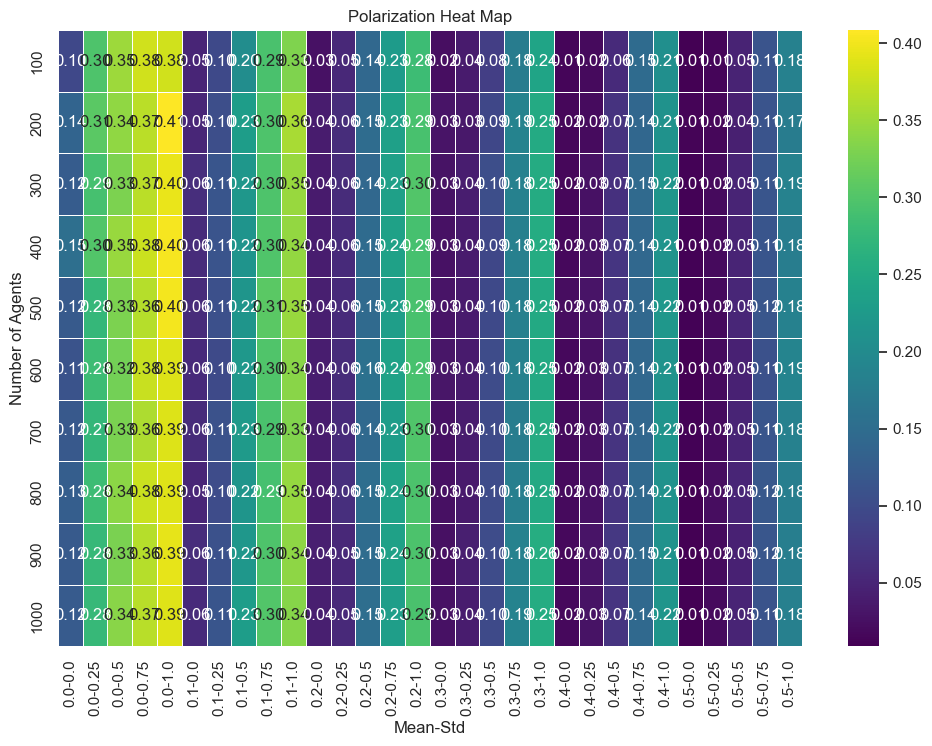

In [49]:
heatmap_data2 = heatmap_data.pivot_table(index='Number of Agents', columns=['Mean', 'Std'], values='Polarization (Actual)')

# Create the heat map
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data2, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Polarization Heat Map')
plt.show()

Let's look at the final position of the batch runs

In [43]:
df2 = df[df['Step'] == 500]

In [44]:
df2.loc[:,'Polarization'] = round(df2['Polarization'], 4)
df2.loc[:, 'Alignment'] = round(df2['Alignment'], 4)

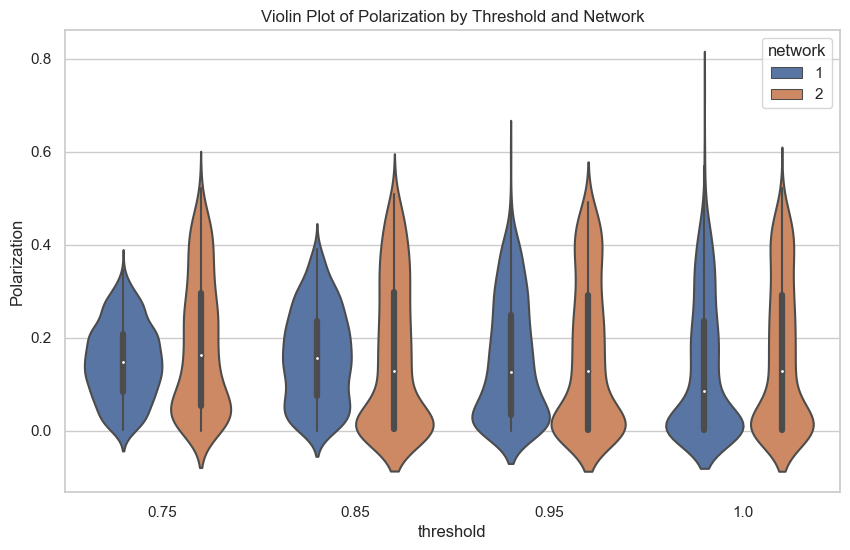

In [45]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))


ax = sns.violinplot(x='threshold', y='Polarization', hue = 'network', data=df2, split=False)

# Add labels and title
ax.set_xlabel('threshold')
ax.set_ylabel('Polarization')
ax.set_title('Violin Plot of Polarization by Threshold and Network')
#plt.savefig('violin_pol.png', bbox_inches='tight')
# Show the plot
plt.show()

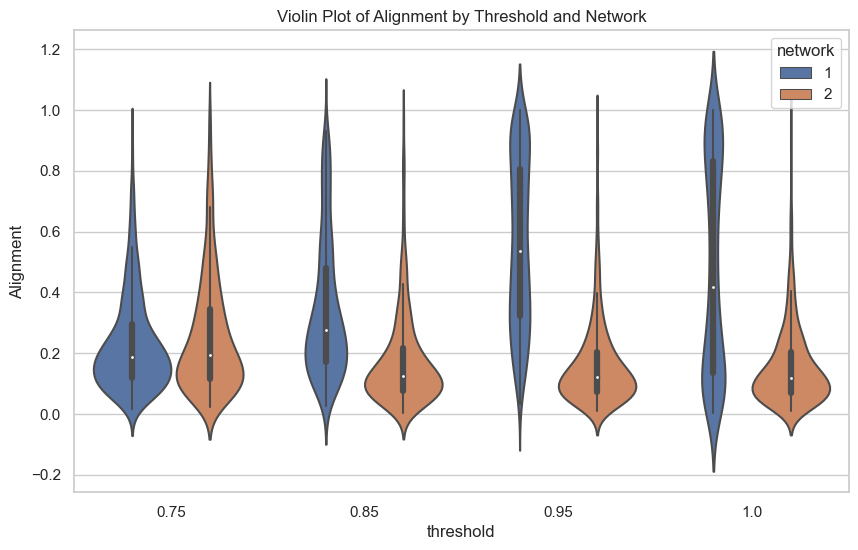

In [46]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))


ax = sns.violinplot(x='threshold', y='Alignment', hue = 'network', data=df2, split=False)

# Add labels and title
ax.set_xlabel('threshold')
ax.set_ylabel('Alignment')
ax.set_title('Violin Plot of Alignment by Threshold and Network')
plt.savefig('violin_align.png', bbox_inches='tight')
# Show the plot
plt.show()

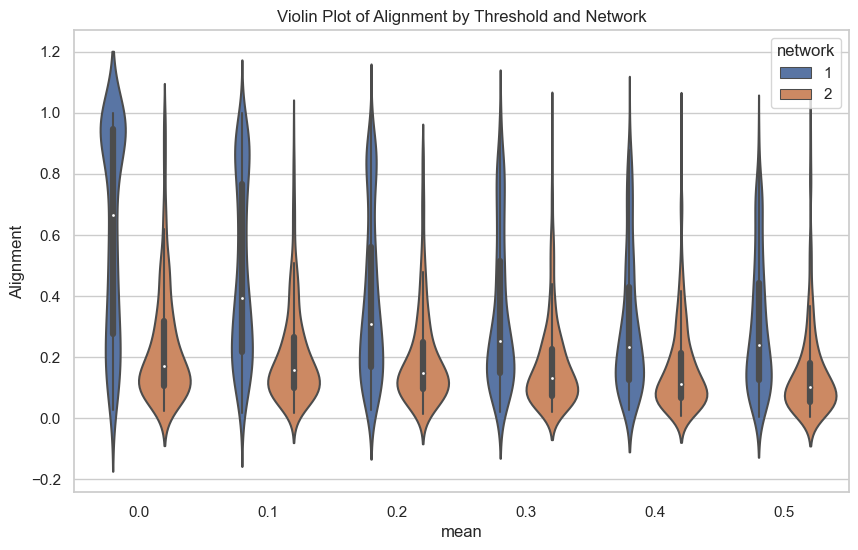

In [47]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))


ax = sns.violinplot(x='mean', y='Alignment', hue = 'network', data=df2, split=False)

# Add labels and title
ax.set_xlabel('mean')
ax.set_ylabel('Alignment')
ax.set_title('Violin Plot of Alignment by Mean and Network')
plt.savefig('violin_align.png', bbox_inches='tight')
# Show the plot
plt.show()

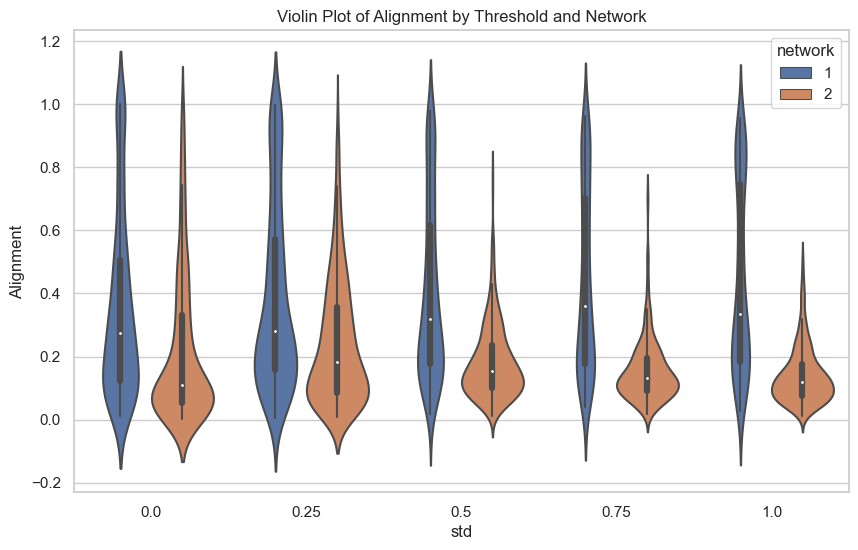

In [48]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))


ax = sns.violinplot(x='std', y='Alignment', hue = 'network', data=df2, split=False)

# Add labels and title
ax.set_xlabel('std')
ax.set_ylabel('Alignment')
ax.set_title('Violin Plot of Alignment by StdM and Network')
plt.savefig('violin_align.png', bbox_inches='tight')
# Show the plot
plt.show()